# Code for Section 4.4 Dynamic Strategies and a Delta Hedging Case Study
This example shows how to compute the P&L of dynamic strategies and compare them at different horizons to buy and hold strategies. Specifically, we examine an equity index

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
from scipy.stats import norm
import matplotlib.pyplot as plt

# Data load

In [3]:
# Load the time series data to extract current values
time_series = ft.load_time_series()

# Load the relevant stationary transformation simulation
st_sim_cumsum = np.load('../chapter3/st_sim_cumsum.npy')

# Initial put and forward pricing

In [4]:
S_0 = time_series['Equity Index'].values[-1]
r_0 = time_series['1m'].values[-1] / 100
q = 0
T = 1 / 12

forward = ft.forward(S_0, r_0, q, T)
print(f'Initial forward price is {np.round(forward, 2)}.')
K = forward  # set the strike K to at-the-money forward (ATMF)

sigma_0 = time_series['1m100'].values[-1] / 100
p_0 = ft.put_option(forward, K, sigma_0, r_0, T)
print(f'Initial 1m ATMF put price is {np.round(p_0, 2)}.')
print(f'Put relative market value is {np.round(100 * p_0 / S_0, 2)}%.')

Initial forward price is 905.36.
Initial 1m ATMF put price is 36.37.
Put relative market value is 4.03%.


In [5]:
def compute_put_delta(F, K, sigma, T):
    # See https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model
    d1 = (np.log(F / K) + sigma**2 * T / 2) / (sigma * np.sqrt(T))
    return -norm.cdf(-d1)

In [6]:
delta_initial = compute_put_delta(forward, K, sigma_0, T)
print(f'Initial put option delta {np.round(100 * delta_initial, 2)}%.')

Initial put option delta -47.99%.


# Simulated P&L comparison

In [37]:
spot_sim = time_series['Equity Index'].values[-1] * np.exp(st_sim_cumsum[:, 0, :])
discount_factor_init = np.exp(-T * time_series['1m'].values[-1] / 100)
discount_factor_sim = discount_factor_init * np.exp(st_sim_cumsum[:, 1, :])
rate_sim = -np.log(discount_factor_sim) / T
vol_sim = time_series['1m100'].values[-1] / 100 * np.exp(st_sim_cumsum[:, 2, :])

In [44]:
S = len(st_sim_cumsum)
horizons = [4, 9, 14, 20]  # Corresponds to one day more as Python indexing starts at 0

# Preallocate space
option_horizon_pnl = np.full((S, len(horizons)), np.nan) # 1w, 2w, 3w, and 1m
strategy_horizon_pnl = np.full((S, len(horizons)), np.nan) # 1w, 2w, 3w, and 1m

In [69]:
for i, horizon in enumerate(horizons):
    F = ft.forward(spot_sim[:, horizon], rate_sim[:, horizon], q, T - horizon / 252)
    option_horizon_pnl[:, i] = ft.put_option(F, K, vol_sim[:, horizon], rate_sim[:, horizon], T - horizon / 252) - p_0

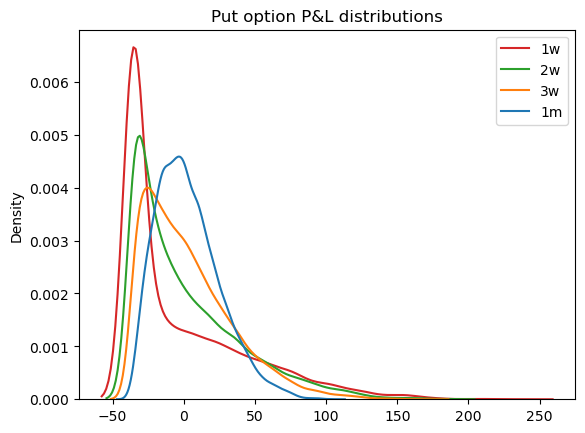

In [70]:
sns.kdeplot(option_horizon_pnl)
plt.legend(['1w', '2w', '3w', '1m'])
plt.title('Put option P&L distributions')
plt.show()